# Examine MTA Bus Archive Data
Jeremy Shaffer (jms995) 

---

NYC MTA bus position data is archived using mta-bus-archive tool: https://github.com/Bus-Data-NYC/mta-bus-archive

According to the README:
> Bus position data for July 2017 forward is archived at https://s3.amazonaws.com/nycbuspositions. Archive files follow the pattern https://s3.amazonaws.com/nycbuspositions/YYYY/MM/YYYY-MM-DD-bus-positions.csv.xz, e.g. https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-14-bus-positions.csv.xz.

In [2]:
# imports
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import urllib

## Search S3 Bucket for Available and Missing Files
1. Generate all URLs in specified date range
2. Try to access each URL
3. Save CSV files containing found URLs and missing URLs separately

In [ ]:
def get_urls_in_date_range(start_date, end_date):
    """
    Returns a list of (date, URL) tuples that correspond to the specified date range.
    Date range is inclusive of both the start_date and end_date.
    
    Example URL: 'https://s3.amazonaws.com/nycbuspositions/YYYY/MM/YYYY-MM-DD-bus-positions.csv.xz'
    
    Parameters:
    start_date: 'YYYY-MM-DD'
    end_date: 'YYYY-MM-DD'
    
    Returns:
    List of tuples (date, URL)
    """
    
    base_url = 'https://s3.amazonaws.com/nycbuspositions/{0}/{1}/{0}-{1}-{2}-bus-positions.csv.xz'
    
    # Python datetime string formatting: https://strftime.org
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d', errors='raise')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d', errors='raise')
    
    date_range_list = pd.date_range(start=start_date, end=end_date).to_list()
    
    url_list = []
    for date in date_range_list:
        url_list.append((date, base_url.format(str(date.year), str(date.month).rjust(2, '0'), str(date.day).rjust(2, '0'))))

    return url_list

In [6]:
# references
# https://www.kite.com/python/answers/how-to-get-yesterday%27s-date-in-python
# https://gist.github.com/dehowell/884204

earliest_date = '2017-07-01'  # earliest possible date according to the mta-bus-archibe GitHub README
yesterday_date = dt.date.today() - dt.timedelta(days=1)  # yesterday's date


In [ ]:

url_date_range_list = get_urls_in_date_range(earliest_date, yesterday_date)

url_found_list = []
url_missing_list = []
for date, url in url_date_range_list:
    try:
        urllib.request.urlopen(url)
        url_found_list.append((date, url))
    except urllib.error.HTTPError as e:
        url_missing_list.append((date, url))

In [ ]:
# references
# https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/

# found URLs as df
url_found_df = pd.DataFrame(url_found_list, columns=['Date', 'URL'])
url_found_df.head()

In [ ]:
# create Year, Month, and Year-Month columns for found URLs df
url_found_df['Year'] = url_found_df['Date'].apply(lambda x: str(x.year))
url_found_df['Month'] = url_found_df['Date'].apply(lambda x: str(x.month).rjust(2, '0'))
url_found_df['Year-Month'] = url_found_df['Year'] + '-' + url_found_df['Month']
url_found_df.head()

In [ ]:
# missing URLs as df
url_missing_df = pd.DataFrame(url_missing_list, columns=['Date', 'URL'])
url_missing_df.head()

In [ ]:
# create Year, Month, and Year-Month columns for missing URLs df
url_missing_df['Year'] = url_missing_df['Date'].apply(lambda x: str(x.year))
url_missing_df['Month'] = url_missing_df['Date'].apply(lambda x: str(x.month).rjust(2, '0'))
url_missing_df['Year-Month'] = url_missing_df['Year'] + '-' + url_found_df['Month']
url_missing_df.head()

In [ ]:
# save found and missing urls to CSVs
url_found_df.to_csv('urls_found.csv', index=False)
url_missing_df.to_csv('urls_missing.csv', index=False)

## Determine When Files Are Missing
1. Read in found URLs from CSV
2. Aggregate count by Year-Month
3. Generate a bar plot

In [3]:
# read in found URLs from CSV
url_found_df = pd.read_csv('urls_found.csv')
url_found_df.head()

,Date,URL,Year,Month,Year-Month
0,2017-07-14,https://s3.amazonaws.com/nycbuspositions/2017/...,2017,7,2017-07
1,2017-07-15,https://s3.amazonaws.com/nycbuspositions/2017/...,2017,7,2017-07
2,2017-07-16,https://s3.amazonaws.com/nycbuspositions/2017/...,2017,7,2017-07
3,2017-07-17,https://s3.amazonaws.com/nycbuspositions/2017/...,2017,7,2017-07
4,2017-07-18,https://s3.amazonaws.com/nycbuspositions/2017/...,2017,7,2017-07


In [4]:
# count number of files that exist for each month in a given year
grouped_count_df = url_found_df[['Year-Month', 'URL']].groupby(by=['Year-Month']).count().rename(columns={'URL': 'URL_Count'})
grouped_count_df.head()

,URL_Count
Year-Month,
2017-07,18
2017-08,31
2017-09,30
2017-10,31
2017-11,30


In [7]:
# reindex to include all dates in range, fill count with 0
# references: https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe

idx = pd.date_range(earliest_date, yesterday_date, freq='MS')
idx = pd.Index(pd.Series(idx).apply(lambda x: str(x.year) + '-' + str(x.month).rjust(2, '0')))
print(idx)

grouped_count_df = grouped_count_df.reindex(idx, fill_value=0).reset_index().rename(columns={'index': 'Year-Month'})
grouped_count_df

Index(['2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07'],
      dtype='object')


,Year-Month,URL_Count
0,2017-07,18
1,2017-08,31
2,2017-09,30
3,2017-10,31
4,2017-11,30
...,...,...
56,2022-03,31
57,2022-04,30
58,2022-05,31
59,2022-06,30


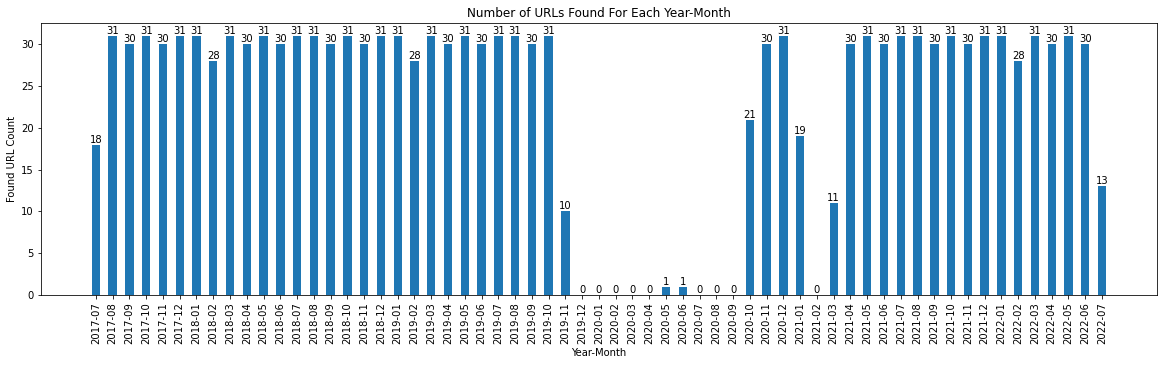

In [8]:
plt.figure(figsize=[20, 5])
plt.bar(x='Year-Month', height='URL_Count', data=grouped_count_df, width=0.5)
plt.xlabel('Year-Month')
plt.ylabel('Found URL Count')
plt.title('Number of URLs Found For Each Year-Month')
plt.xticks(rotation=90)

# reference: https://www.kite.com/python/answers/how-to-display-the-value-of-each-bar-in-a-bar-chart-using-matplotlib-in-python
for index, value in enumerate(grouped_count_df['URL_Count']):
    plt.text(x=index, y=value, s=str(value), ha='center', va='bottom')

plt.show()

In [10]:
# added by Anthony Townsend
## download files
import requests

for index, row in url_found_df.iterrows():
    try:
        print(row['URL'])
        response = requests.get(row['URL'])
        filename=row['URL'].split('/')[-1]
        open(f'/Users/anthonytownsend/Downloads/transitcenter/transitcenter_{filename}', 'wb').write(response.content)
    except Exception as e:
        print(f"{row['URL']} {e}")


https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-14-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-15-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-16-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-17-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-18-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-19-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-20-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-21-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-22-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-23-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-24-bus-positions.csv.xz
https://s3.amazonaws.com/nycbuspositions/2017/07/2017-07-25-bus-positions.csv.xz
https://s3.amazonaws.com/nyc